In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from numpy.random import seed
seed(123)


2.10.1


# Zad
Porównaj wyniki działań różnych optymalizacji


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

train_set = pd.read_csv(data_url, sep=", ",header = None)
test_set = pd.read_csv(test_url, sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


C:\Users\krzys\AppData\Local\Temp\ipykernel_8996\2049605904.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv(data_url, sep=", ",header = None)
C:\Users\krzys\AppData\Local\Temp\ipykernel_8996\2049605904.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv(test_url, sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

C:\Users\krzys\AppData\Local\Temp\ipykernel_8996\2529606137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})
C:\Users\krzys\AppData\Local\Temp\ipykernel_8996\2529606137.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['native_country'] = dataset['native_country'].replace(d)


(30162, 41)


(15060, 41)

# SGD

In [4]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [5]:
sgd = tf.keras.optimizers.legacy.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

D:\Anaconda\envs\experiments\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 3s 2ms/step - loss: 0.4943 - accuracy: 0.7659 - val_loss: 0.3666 - val_accuracy: 0.8330
Epoch 2/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3485 - accuracy: 0.8358 - val_loss: 0.3411 - val_accuracy: 0.8373
Epoch 3/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3362 - accuracy: 0.8425 - val_loss: 0.3349 - val_accuracy: 0.8411
Epoch 4/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3317 - accuracy: 0.8432 - val_loss: 0.3337 - val_accuracy: 0.8442
Epoch 5/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3291 - accuracy: 0.8450 - val_loss: 0.3387 - val_accuracy: 0.8449
Epoch 6/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3279 - accuracy: 0.8457 - val_loss: 0.3272 - val_accuracy: 0.8454
Epoch 7/100
943/943 [==============================] - 2s 2ms/step - loss: 0.3271 - accuracy: 0.8462 - val_loss: 0.3342 - val_accuracy: 0.8426

In [7]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

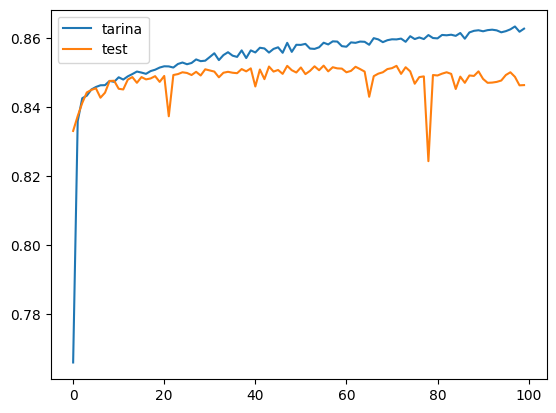

In [8]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Użyjmy LearningRateScheduler

In [9]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lr_1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer="SGD", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_lr_1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4200      
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 8s 7ms/step - loss: 0.5614 - accuracy: 0.7511 - val_loss: 0.5537 - val_accuracy: 0.7543 - lr: 0.0100
Epoch 2/100
943/943 [=======

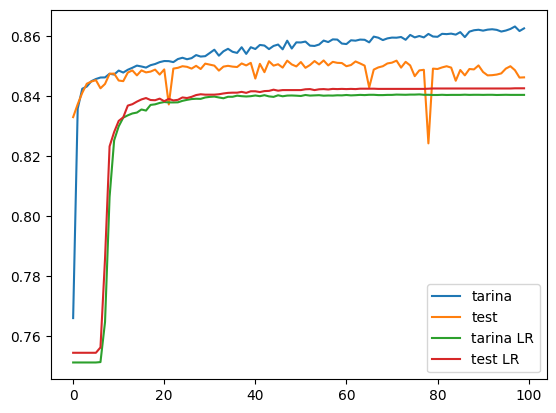

In [10]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")

plt.plot(history_lr_1.history['accuracy'], label = "tarina LR")
plt.plot(history_lr_1.history['val_accuracy'], label = "test LR")
plt.legend()
plt.show()

# Zad

Wykonaj analogiczne zadanie dla 
* Adam bez LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.001
* Adam z użyciem LearningRateScheduler i learning_rate=0.0001

Zwizualizuj wyniki:

* porównaj krzywe uczenia

# Adam

In [13]:


history_lr_001 = History()
model_adam = Sequential()
model_adam.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model_adam.add(Dense(50,activation="sigmoid"))
model_adam.add(Dense(10,activation="sigmoid"))
model_adam.add(Dense(1,activation="sigmoid"))
model_adam.summary()

adam = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
model_adam.compile(loss="binary_crossentropy",optimizer=adam, metrics=["accuracy"])


model_adam.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=10, callbacks=[history_lr_001])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               4200      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


D:\Anaconda\envs\experiments\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


943/943 [==============================] - 3s 2ms/step - loss: 0.3463 - accuracy: 0.8406 - val_loss: 0.3326 - val_accuracy: 0.8432
Epoch 2/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3275 - accuracy: 0.8465 - val_loss: 0.3251 - val_accuracy: 0.8477
Epoch 3/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3209 - accuracy: 0.8514 - val_loss: 0.3345 - val_accuracy: 0.8452
Epoch 4/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3155 - accuracy: 0.8537 - val_loss: 0.3240 - val_accuracy: 0.8478
Epoch 5/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3120 - accuracy: 0.8549 - val_loss: 0.3256 - val_accuracy: 0.8499
Epoch 6/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3074 - accuracy: 0.8567 - val_loss: 0.3188 - val_accuracy: 0.8514
Epoch 7/10
943/943 [==============================] - 2s 2ms/step - loss: 0.3054 - accuracy: 0.8577 - val_loss: 0.3205 - val_accuracy: 0.8525
Epoch 8/10
943/94

In [15]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lrs_001 = History()
model_lrs_001 = Sequential()
model_lrs_001.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model_lrs_001.add(Dense(50,activation="sigmoid"))
model_lrs_001.add(Dense(10,activation="sigmoid"))
model_lrs_001.add(Dense(1,activation="sigmoid"))
model_lrs_001.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_lrs_001.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model_lrs_001.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=10, callbacks=[lrate, history_lrs_001])


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               4200      
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 dense_26 (Dense)            (None, 10)                510       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
943/943 [==============================] - 3s 2ms/step - loss: 0.3785 - accuracy: 0.8259 - val_loss: 0.3405 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 2/10
943/943 [=========

In [16]:
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

history_lrs_0001 = History()
model_lrs_0001 = Sequential()
model_lrs_0001.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model_lrs_0001.add(Dense(50,activation="sigmoid"))
model_lrs_0001.add(Dense(10,activation="sigmoid"))
model_lrs_0001.add(Dense(1,activation="sigmoid"))
model_lrs_0001.summary()

# sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_lrs_0001.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model_lrs_0001.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=10, callbacks=[lrate, history_lrs_0001])


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               4200      
                                                                 
 dense_29 (Dense)            (None, 50)                5050      
                                                                 
 dense_30 (Dense)            (None, 10)                510       
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
943/943 [==============================] - 3s 2ms/step - loss: 0.5348 - accuracy: 0.7511 - val_loss: 0.4729 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/10
943/943 [=====

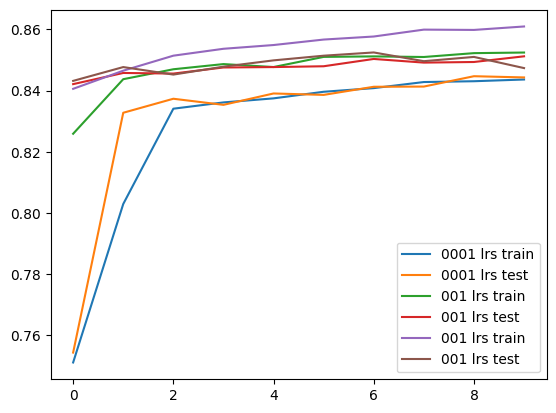

In [17]:
plt.plot(history_lrs_0001.history['accuracy'],label = '0001 lrs train')
plt.plot(history_lrs_0001.history['val_accuracy'],label = '0001 lrs test')
plt.plot(history_lrs_001.history['accuracy'],label = '001 lrs train')
plt.plot(history_lrs_001.history['val_accuracy'],label = '001 lrs test')
plt.plot(history_lr_001.history['accuracy'],label = '001 lrs train')
plt.plot(history_lr_001.history['val_accuracy'],label = '001 lrs test')
plt.legend()
plt.show()